**1. Импортирование библиотек, загрузка данных, определение признаков, заполнение пропусков, вывод информации о пропусках:**

Количество пропусков в каждом столбце:
Series([], dtype: int64)


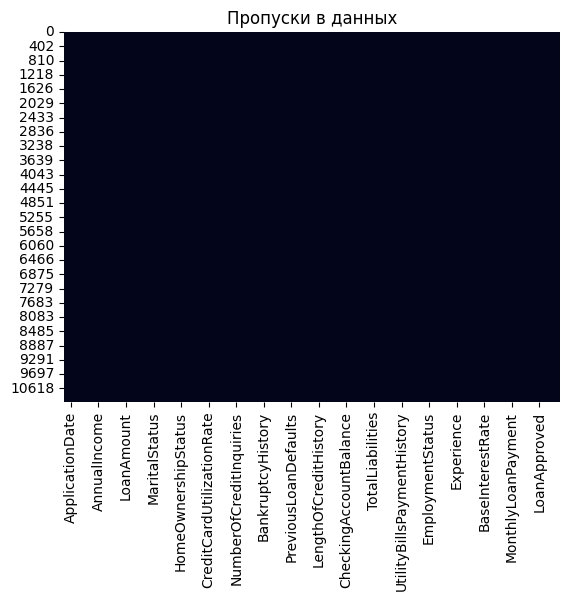

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Загрузка данных
data_path = 'train.csv'
data = pd.read_csv(data_path)

# Определение числовых и категориальных признаков
num_cols = data.select_dtypes(include=['number']).columns.tolist()
cat_cols = data.select_dtypes(include=['object']).columns.tolist()

# Обработка временных признаков
for col in cat_cols:
    if pd.api.types.is_datetime64_any_dtype(data[col]):
        data[col] = pd.to_datetime(data[col]).astype(int) / 10**9  # Преобразование в секунды

# Удаление строк с пропущенными значениями для обработки категориальных признаков
data = data.dropna(subset=cat_cols)

# Заполнение пропусков в числовых признаках с использованием KNNImputer
num_imputer = KNNImputer(n_neighbors=5)
data[num_cols] = num_imputer.fit_transform(data[num_cols])

# Кодирование категориальных признаков
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Сохраняем энкодер для возможного обратного преобразования

# Проверка на наличие пропусков
missing_values = data.isnull().sum()
print("Количество пропусков в каждом столбце:")
print(missing_values[missing_values > 0])

# Визуализация пропусков
sns.heatmap(data.isnull(), cbar=False)
plt.title('Пропуски в данных')
plt.show()


**2. Удаление дубликатов, фильтрация**

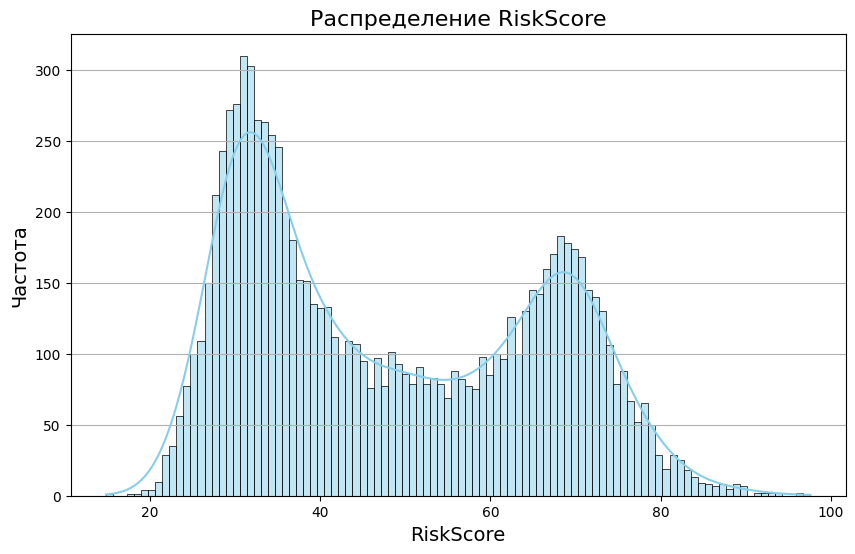

Статистика по числовым признакам:

                       Признак      Максимум       Минимум        Среднее  \
0                          Age  8.000000e+01     18.000000      39.881162   
1                 AnnualIncome  7.485080e+05  15000.000000  131643.614231   
2                  CreditScore  8.500000e+02    300.000000     678.069224   
3                   LoanAmount  4.189970e+05   1063.000000   29806.541470   
4                 LoanDuration  1.200000e+02     12.000000      53.382769   
5           NumberOfDependents  6.000000e+00      0.000000       1.566652   
6          MonthlyDebtPayments  1.087900e+04     13.000000     546.931955   
7    CreditCardUtilizationRate  9.146347e-01      0.003674       0.284982   
8      NumberOfOpenCreditLines  1.200000e+01      0.000000       3.031183   
9      NumberOfCreditInquiries  6.000000e+00      0.000000       0.979747   
10           DebtToIncomeRatio  8.658418e-01      0.003227       0.250089   
11           BankruptcyHistory  1.000000e

In [13]:
# Удаление дубликатов из набора данных
data = data.drop_duplicates()

# Фильтрация значений RiskScore, оставляя только те, которые находятся в пределах от 0 до 100
risk_filter = data['RiskScore'].between(0, 100)
data = data[risk_filter]

# Визуализация распределения целевого значения RiskScore с помощью гистограммы
plt.figure(figsize=(10, 6))
sns.histplot(data['RiskScore'], bins=100, kde=True, color='skyblue')
plt.title('Распределение RiskScore', fontsize=16)
plt.xlabel('RiskScore', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.grid(axis='y')
plt.show()

# Печать статистики по числовым признакам
print("Статистика по числовым признакам:\n")
stats = []

for num_col in num_cols:
    max_val = data[num_col].max()
    min_val = data[num_col].min()
    mean_val = data[num_col].mean()
    std_dev = data[num_col].std()
    stats.append({'Признак': num_col, 'Максимум': max_val, 'Минимум': min_val,
                   'Среднее': mean_val, 'Стандартное отклонение': std_dev})

# Создание DataFrame для статистики
stats_df = pd.DataFrame(stats)

print(stats_df)


**3. Оценка корреляции целевого признака, отбор признаков**

Корреляция целевого признака со всеми остальными числовыми признаками:

RiskScore                     1.000000
BaseInterestRate              0.759546
InterestRate                  0.744193
TotalDebtToIncomeRatio        0.554352
BankruptcyHistory             0.179697
MonthlyLoanPayment            0.147417
DebtToIncomeRatio             0.109422
LoanAmount                    0.079041
PreviousLoanDefaults          0.055248
CreditCardUtilizationRate     0.053080
LoanDuration                  0.025265
UtilityBillsPaymentHistory    0.021388
TotalLiabilities              0.018201
MonthlyDebtPayments           0.017922
JobTenure                     0.014337
PaymentHistory                0.014103
NumberOfDependents            0.008190
NumberOfOpenCreditLines      -0.001151
SavingsAccountBalance        -0.002926
CheckingAccountBalance       -0.007520
NumberOfCreditInquiries      -0.016172
Age                          -0.042744
Experience                   -0.044865
LengthOfCreditHistory        -0

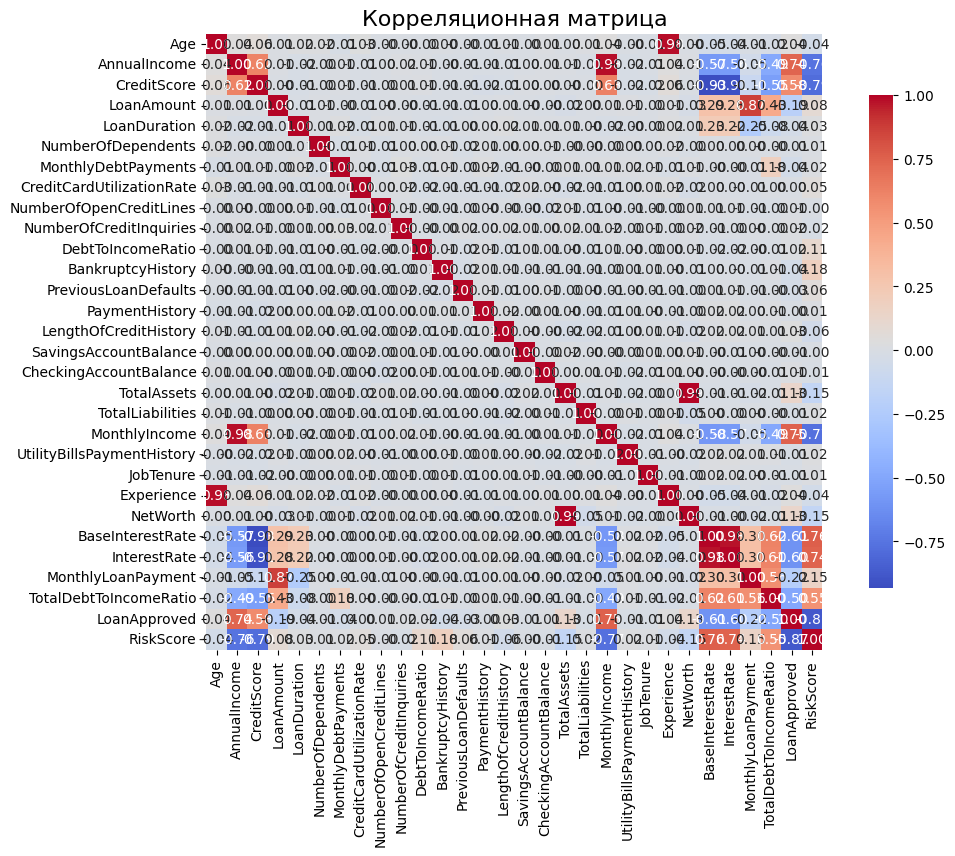


Выбранные признаки для модели:
['BaseInterestRate', 'InterestRate', 'TotalDebtToIncomeRatio', 'BankruptcyHistory', 'MonthlyLoanPayment', 'DebtToIncomeRatio', 'LoanAmount', 'PreviousLoanDefaults', 'CreditCardUtilizationRate', 'LoanDuration', 'UtilityBillsPaymentHistory', 'TotalLiabilities', 'MonthlyDebtPayments', 'JobTenure', 'PaymentHistory', 'NumberOfCreditInquiries', 'Age', 'Experience', 'LengthOfCreditHistory', 'NetWorth', 'TotalAssets', 'AnnualIncome', 'MonthlyIncome', 'CreditScore', 'LoanApproved']


In [14]:
# Вычисление корреляционной матрицы для числовых признаков
correlation_matrix = data.select_dtypes(include=['float64', 'int64']).corr()

# Выделение целевого признака
target_column = data.columns[-1]

# Получение категориальных признаков
categorical_columns = data.select_dtypes(include=['object']).columns.tolist() 

# Сортировка корреляции целевого признака с остальными признаками
correlation_with_target = correlation_matrix[target_column].sort_values(ascending=False)

print("Корреляция целевого признака со всеми остальными числовыми признаками:\n")
print(correlation_with_target)

# Отбор признаков с корреляцией по модулю больше 0.01
important_features = correlation_with_target[correlation_with_target.abs() > 0.01].index.tolist()
important_features.remove(target_column)

# Визуализация корреляционной матрицы
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Корреляционная матрица', fontsize=16)
plt.show()

# Вывод списка выбранных признаков
print("\nВыбранные признаки для модели:")
print(important_features)


**4. Обработка мультикорреляций, определение списка отобранных признаков**

In [15]:
# Вычисление мультикорреляций (корреляция по модулю >= 0.8)
multi_correlation = correlation_matrix.unstack().loc[lambda x: (x.abs() >= 0.8) & (x != 1.0)]
print("\nПризнаки с мультикорреляцией (корреляция по модулю >= 0.8):")

# Хранение уникальных пар признаков
unique_feature_pairs = set()

# Определение уникальных пар признаков с мультикорреляцией
for (feature_a, feature_b), correlation_value in multi_correlation.items():
    if feature_a in important_features and feature_b in important_features:
        unique_feature_pairs.add(tuple(sorted([feature_a, feature_b])))

# Вывод уникальных пар признаков
for pair in unique_feature_pairs:
    print(f"Пара: {pair[0]}, {pair[1]}")

# Определение признаков для удаления
features_to_remove = []
for feature_a, feature_b in unique_feature_pairs:
    if feature_a in important_features:
        features_to_remove.append(feature_b)

# Окончательный список отобранных признаков
final_selected_features = list(set(important_features) - set(features_to_remove))

print("\nФинальный список выбранных числовых признаков:")
print(final_selected_features)



Признаки с мультикорреляцией (корреляция по модулю >= 0.8):
Пара: NetWorth, TotalAssets
Пара: AnnualIncome, MonthlyIncome
Пара: LoanAmount, MonthlyLoanPayment
Пара: BaseInterestRate, CreditScore
Пара: Age, Experience
Пара: CreditScore, InterestRate
Пара: BaseInterestRate, InterestRate

Финальный список выбранных числовых признаков:
['LoanAmount', 'NetWorth', 'JobTenure', 'BankruptcyHistory', 'PaymentHistory', 'BaseInterestRate', 'LoanDuration', 'MonthlyDebtPayments', 'TotalDebtToIncomeRatio', 'PreviousLoanDefaults', 'LoanApproved', 'TotalLiabilities', 'DebtToIncomeRatio', 'UtilityBillsPaymentHistory', 'Age', 'LengthOfCreditHistory', 'AnnualIncome', 'NumberOfCreditInquiries', 'CreditCardUtilizationRate']


**5. Преобразование категориальных признаков в числовые, оценка производительности**

In [18]:
# Код для кодирования категориальных признаков
label_encoder = LabelEncoder()
for category in categorical_columns:
    data[category] = label_encoder.fit_transform(data[category])

# Определение признаков и целевой переменной
features = data[categorical_columns]
target_variable = data[target_column]

# Нормализация числовых признаков
scaler = StandardScaler()
features_scaled = scaler.fit_transform(data[final_selected_features])

# Объединение нормализованных и категориальных признаков
features_combined = np.concatenate([features_scaled, features], axis=1)

# Разделение данных на обучающую и тестовую выборки
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(features_combined, target_variable, test_size=0.2, random_state=42)

# Инициализация и обучение модели линейной регрессии
linear_model = LinearRegression()
linear_model.fit(X_train_set, y_train_set)

# Предсказание значений на тестовой выборке
predictions = linear_model.predict(X_test_set)

# Оценка производительности модели на тестовых данных
print("\nРезультаты оценки модели на тестовых данных:")
print('Среднеквадратичная ошибка (MSE):', mean_squared_error(y_test_set, predictions))
print('Корень среднеквадратичной ошибки (RMSE):', np.sqrt(mean_squared_error(y_test_set, predictions)))
print('Средняя абсолютная ошибка (MAE):', mean_absolute_error(y_test_set, predictions))



Результаты оценки модели на тестовых данных:
Среднеквадратичная ошибка (MSE): 20.509790001248042
Корень среднеквадратичной ошибки (RMSE): 4.528773564801848
Средняя абсолютная ошибка (MAE): 3.54612100086927


**6. Регуляризация**

In [21]:
# Ridge-регуляризация
ridge_model = Ridge(
    alpha=5,
    fit_intercept=True,
    max_iter=1000,
    tol=1e-4,
    solver='auto'
)

# Обучение модели Ridge
ridge_model.fit(X_train_set, y_train_set)
ridge_predictions = ridge_model.predict(X_test_set)

# Оценка производительности модели Ridge
ridge_mse = mean_squared_error(y_test_set, ridge_predictions)
print(f"MSE для Ridge-регрессии: {ridge_mse:.4f}")

# Lasso-регуляризация
lasso_model = Lasso(
    alpha=0.001,
    fit_intercept=True,
    max_iter=10000,
    tol=1e-4,
    precompute=True,
    warm_start=False,
    positive=False
)

# Обучение модели Lasso
lasso_model.fit(X_train_set, y_train_set)
lasso_predictions = lasso_model.predict(X_test_set)

# Оценка производительности модели Lasso
lasso_mse = mean_squared_error(y_test_set, lasso_predictions)
print(f"MSE для Lasso-регрессии: {lasso_mse:.4f}")

# Elastic-регуляризация
elastic_model = ElasticNet(
    alpha=0.00012,
    l1_ratio=0.8,
    fit_intercept=True,
    max_iter=10000,
    tol=1e-4,
    precompute=True,
    warm_start=False,
    positive=False
)

# Обучение модели ElasticNet
elastic_model.fit(X_train_set, y_train_set)
elastic_predictions = elastic_model.predict(X_test_set)

# Оценка производительности модели ElasticNet
elastic_mse = mean_squared_error(y_test_set, elastic_predictions)
print(f"MSE для ElasticNet-регрессии: {elastic_mse:.4f}")


MSE для Ridge-регрессии: 20.5124
MSE для Lasso-регрессии: 20.5081
MSE для ElasticNet-регрессии: 20.5097


**7. Вывод результатов, выгрузка в csv**

In [22]:
test_data = pd.read_csv('test.csv')
test_ids = test_data['ID']

# Подготовка данных для предсказаний: кодируем категориальные признаки
label_encoder_test = LabelEncoder()
for cat_col in categorical_columns:
    test_data[cat_col] = label_encoder_test.fit_transform(test_data[cat_col])

# Извлекаем кодированные категориальные признаки
categorical_features_test = test_data[categorical_columns]

# Нормализуем числовые признаки
feature_scaler = StandardScaler()
scaled_features_test = feature_scaler.fit_transform(test_data[final_selected_features])

# Объединяем нормализованные числовые и категориальные признаки
final_test_features = np.concatenate([scaled_features_test, categorical_features_test], axis=1)

# Предсказание значений RiskScore на тестовых данных
predicted_risk_score = linear_model.predict(final_test_features)

# Формируем результат и выводим его
predicted_results = pd.DataFrame({'ID': test_ids, 'RiskScore': predicted_risk_score})
print(predicted_results)

# Сохраняем предсказания в .csv файл
predicted_results.to_csv('submission.csv', index=False)


        ID  RiskScore
0        0  33.255795
1        1  57.732778
2        2  30.696629
3        3  31.833047
4        4  35.530516
...    ...        ...
4995  4995  31.638587
4996  4996  60.581393
4997  4997  63.675462
4998  4998  51.470637
4999  4999  86.195264

[5000 rows x 2 columns]
